<a href="https://colab.research.google.com/github/GRBF20/HSM-Classifier/blob/master/HSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#connect Drive
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/TEMAS DIVERSOS - PESQUISA/PROJETOS PYTHON/vibracoes classifier')

In [0]:
!ls

'2010 - dissertationPhD.pdf'	   'HSMClassifier(SugestaoMateus).py'
 CLASSIFIER.py			    HSMCOLAB.ipynb
'dados prof. eloi e k worden.zip'   PreparandoDADOS.asv
 data3SS20092.mat		    PreparandoDADOS.m
 data3SS2009.mat		    SHMClassifier.py
 formato_dados.txt		   'SHMClassifier(SugestaoMateus).py'
'HSMClassifier(4Classifiers).py'    tr.pdf


In [0]:
##SETUP

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

#KERAS
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

#Imports
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from IPython.display import Image,display
import pydot
# to make this notebook's output stable across runs
np.random.seed(42)



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [0]:
#LOADING DATASET
dataset=sio.loadmat('data3SS20092')
##

In [0]:
##PREPARING DATA
x_raw=dataset['datasetx']
y_raw=dataset['labels']

#x=np.reshape(x_raw,(850,40960))
scaler= MinMaxScaler()
x_scaled=scaler.fit_transform(x_raw)

y=np.zeros(shape=(len(y_raw),1))
for i in range(0,len(y)):
    if y_raw[i]<=9:
         y[i]=1
    else:
        y[i]=-1
##

In [0]:
##DIMENSIONALITY REDUCTION PCA
pca = PCA(n_components = 0.95)              #reduce to n PC's maintaining a 95% ratio of variance
X_red = pca.fit_transform(x_raw)
print(X_red.shape)
##

(850, 6)


# **DECISION TREE**

In [0]:
##Cross Validation
param_grid = {'max_leaf_nodes': list(range(2,100)), 
              'min_samples_split':[3, 4, 5],
              'max_depth':[10,20,30],
              },
rskf= RepeatedStratifiedKFold(n_splits=10, n_repeats=5,random_state=42)      
dec_tree = DecisionTreeClassifier(random_state=42)
rand_search = RandomizedSearchCV(dec_tree, param_grid, cv=rskf)

rand_search.fit(X_red, y)

display(rand_search.best_params_)
##

{'max_depth': 10, 'max_leaf_nodes': 16, 'min_samples_split': 5}

In [0]:
##SPLIT TRAINING SET AND TEST SET
split=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_red, y):
    X_train, X_test = X_red[train_index], X_red[test_index]
    y_train, y_test = y[train_index], y[test_index]
##

In [0]:
##Training the best model on the full training set
dec_tree_best=rand_search.best_estimator_
dec_tree_best.fit(X_train,y_train)
##

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=16,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [0]:
##Accuracy/f1 Score for the training data
y_pred = dec_tree_best.predict(X_train)
display(accuracy_score(y_train, y_pred))
display(f1_score(y_train,y_pred))
##

0.9102941176470588

0.9204693611473272

In [0]:
##Evaluating the system on the Test Set
final_model=dec_tree_best
final_predictions=final_model.predict(X_test)
##

In [0]:
##Accuracy/f1 Score of the final model
display(accuracy_score(y_test, final_predictions))
display(f1_score(y_test, final_predictions))
##

0.8176470588235294

0.8426395939086295

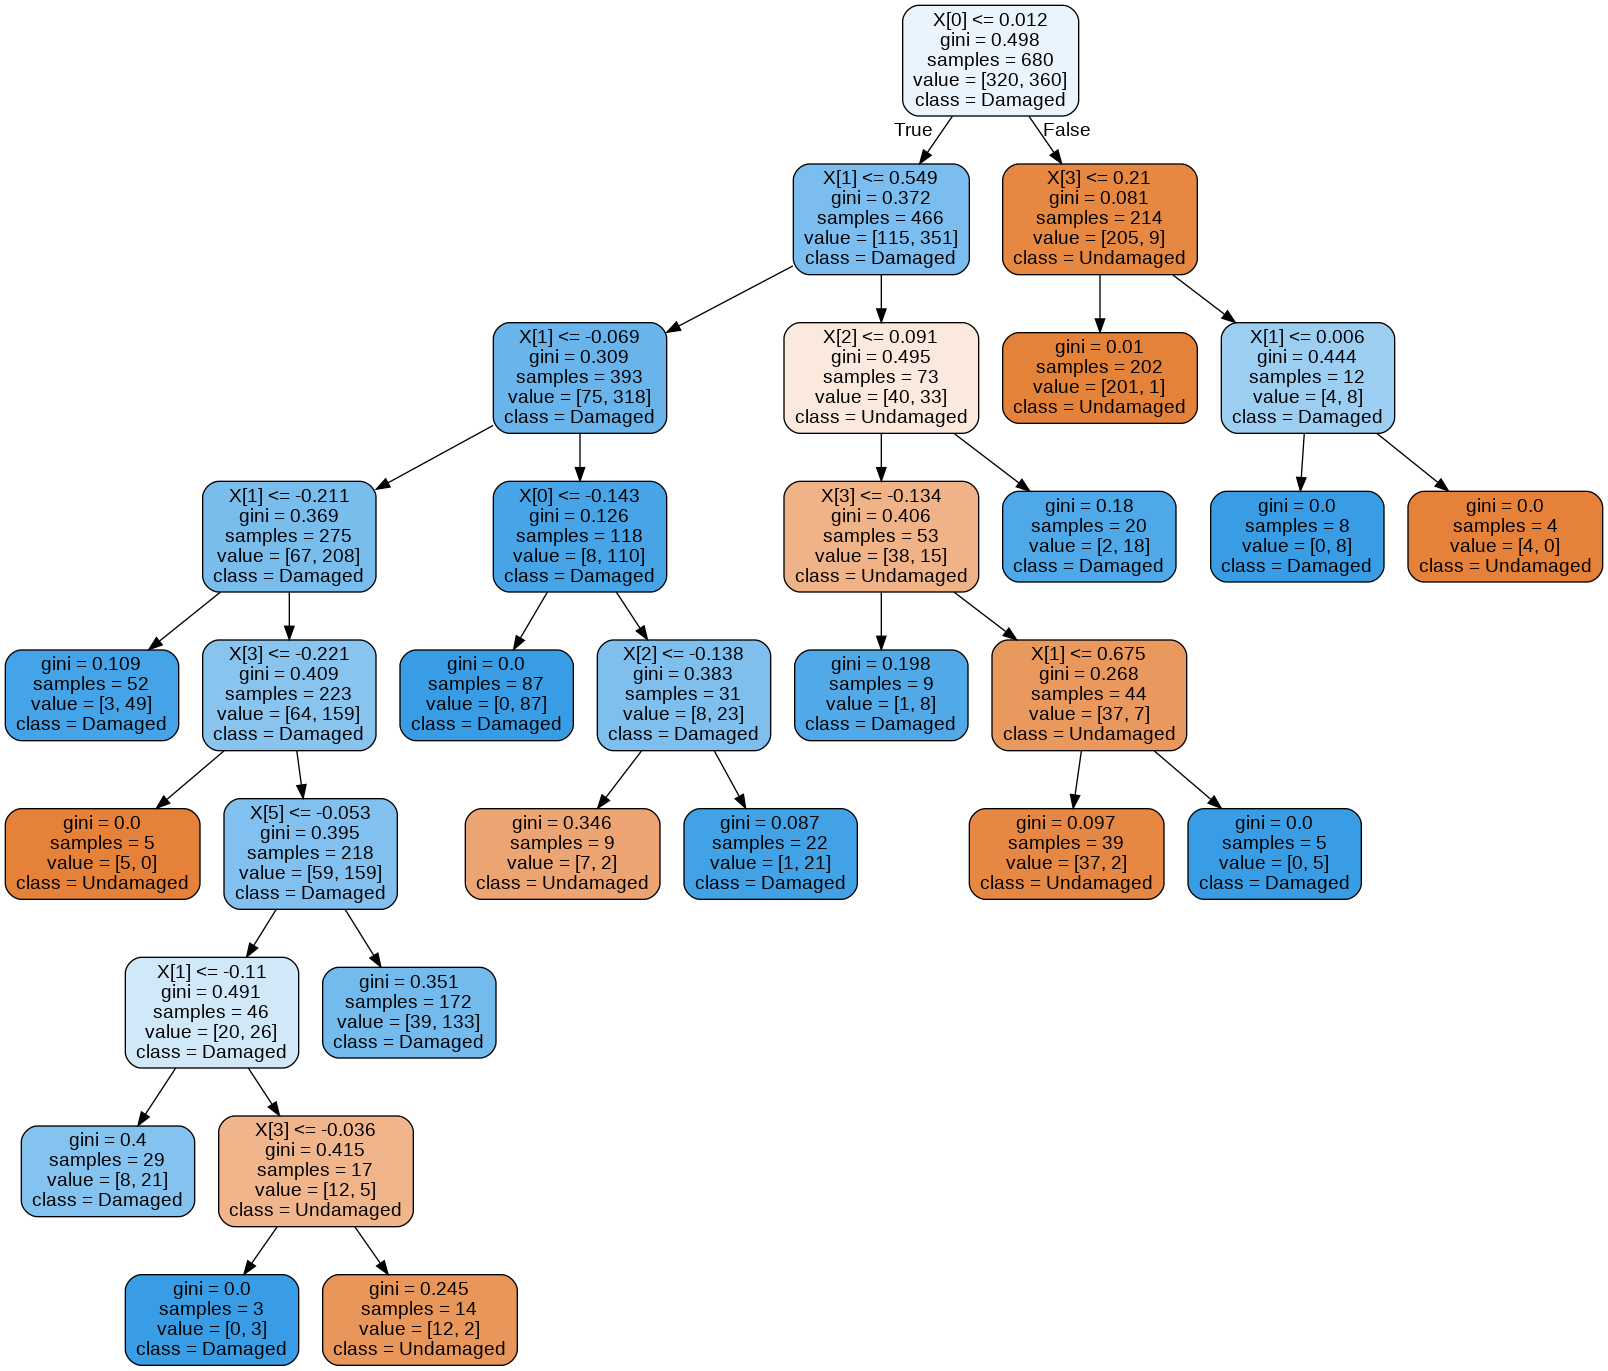

In [0]:
##Visualizing the Decision Tree
dot_data=StringIO()
export_graphviz(final_model,
                out_file=dot_data,
                class_names=['Undamaged','Damaged'],
                rounded=True,
                filled=True
                )

graph=pydot.graph_from_dot_data(dot_data.getvalue())
display(Image(graph[0].create_png()))
##

In [0]:
##Confusion Matrix
conf_matrix=confusion_matrix(y_test,final_predictions)
display(conf_matrix)
##

array([[56, 24],
       [ 7, 83]])

# **RANDOM FOREST CLASSIFIER**

In [0]:
y_train=np.ravel(y_train)

In [0]:
##Cross Validation
param_grid = {'n_estimators': [10,100,1000],                                       
               'max_features': ["sqrt", "log2"]
              }
rskf= RepeatedStratifiedKFold(n_splits=10, n_repeats=5,random_state=42)      
rand_for = RandomForestClassifier(n_jobs=-1)
rand_search = RandomizedSearchCV(rand_for, param_grid,scoring='accuracy', cv=rskf)

rand_search.fit(X_train, y_train)

display(rand_search.best_params_)
display(rand_search.best_score_)
##

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'max_features': 'log2', 'n_estimators': 1000}

0.8876470588235295

In [0]:
##Evaluating the system on the Test Set
y_pred=rand_search.predict(X_test)
accuracy_score(y_test, y_pred)
##

0.8705882352941177

In [0]:
##Confusion Matrix
conf_matrix=confusion_matrix(y_test,y_pred)
display(conf_matrix)
##

array([[60, 20],
       [ 2, 88]])

# **KNEIGHBORS CLASSIFIER**

In [0]:
##Cross Validation
param_grid = {'n_neighbors':[3,5,7,11,13,15],              
             'weights': ["uniform", "distance"],
              'metric':["euclidean","manhattan","minkowski"]
    }       
rskf= RepeatedStratifiedKFold(n_splits=10, n_repeats=5,random_state=42)      
kneighbor = KNeighborsClassifier()
rand_search = RandomizedSearchCV(kneighbor, param_grid,scoring='accuracy', cv=rskf)

rand_search.fit(X_train, y_train)

display(rand_search.best_params_)
display(rand_search.best_score_)
##

{'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'distance'}

0.8814705882352942

In [0]:
##Evaluating the system on the Test Set
y_pred=rand_search.predict(X_test)
accuracy_score(y_test, y_pred)
##

0.888235294117647

In [0]:
##Confusion Matrix
conf_matrix=confusion_matrix(y_test,y_pred)
display(conf_matrix)
##

array([[67, 13],
       [ 6, 84]])